# 4.1 Illustrating Different Keras Optimizers

This notebook demonstrates the behavior of several common optimization algorithms available in Keras:
1. SGD with Momentum
2. SGD with Nesterov Momentum
3. Adagrad
4. Adadelta
5. Adam

We will use a simple neural network on a synthetic 2D binary classification dataset (`make_moons`).
Finally, we will compute the average test performance over 10 experiments with different random seeds.

**Brief Overview of Optimizers:**
*   **SGD with Momentum:**
    *   Helps accelerate SGD in the relevant direction and dampens oscillations. It adds a fraction (`momentum`) of the previous update vector to the current update vector.
    *   Think of a ball rolling down a hill; it accumulates momentum.
      

*   **SGD with Nesterov Momentum (NAG - Nesterov Accelerated Gradient):**
    *   A modification of momentum. It calculates the gradient *after* applying the "look-ahead" momentum step. This allows it to "look ahead" and correct its course more effectively, often leading to better convergence, especially in situations with sharp turns in the loss landscape.
      

*   **Adagrad (Adaptive Gradient Algorithm):**
    *   Adapts the learning rate to the parameters, performing smaller updates for frequently occurring features and larger updates for infrequent features.
    *   It accumulates the sum of squared past gradients for each parameter, and the learning rate is divided by the square root of this sum.
    *   *Potential Issue:* The learning rate can become infinitesimally small over time, potentially stopping learning prematurely.


*   **Adadelta:**
    *   An extension of Adagrad that seeks to reduce its aggressive, monotonically decreasing learning rate.
    *   It restricts the window of accumulated past gradients to some fixed size `w` (conceptually, not explicitly stored). It doesn't require a manually set global learning rate.


*   **Adam (Adaptive Moment Estimation):**
    *   Combines ideas from Momentum (stores an exponentially decaying average of past gradients - first moment) and RMSProp (stores an exponentially decaying average of past squared gradients - second moment, similar to Adagrad/Adadelta).
    *   It computes adaptive learning rates for each parameter. Generally performs well across a wide range of problems and is often a good default choice.

## Load the Required Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import SGD, Adagrad, Adadelta, Adam

# For overall reproducibility of the first run if seeds aren't changed within loops
np.random.seed(42)
tf.random.set_seed(42)

## Generate and Prepare Data
We use `make_moons` to create a dataset that is not linearly separable.

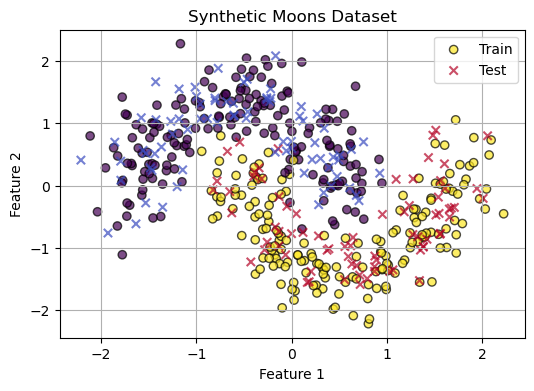

X_train shape: (350, 2)
y_train shape: (350,)


In [2]:
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features (important for many optimizers and neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Plot the dataset
plt.figure(figsize=(6, 4))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', edgecolors='k', alpha=0.7, label='Train')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm', alpha=0.7, marker='x', label='Test') # Removed edgecolors for 'x'
plt.title("Synthetic Moons Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

## Define a Simple Neural Network Model
A small FCNN for binary classification. The seed for weight initialization will be controlled by the loop in Task 8 for repeated experiments, or by the global seed for single runs.

In [3]:
def create_model():
    # The tf.random.set_seed() call that controls weight initialization
    # should be done *before* calling this function in loops for multiple experiments.
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(10, activation='relu', kernel_initializer='he_normal'), # A small hidden layer
        Dense(1, activation='sigmoid') # Output layer for binary classification
    ])
    return model

# Test model creation (will use global seed 42 here)
tf.random.set_seed(42) # Explicitly set for this test summary
test_model = create_model()
test_model.summary()

2025-06-15 00:30:53.474011: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-06-15 00:30:53.474032: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-06-15 00:30:53.474037: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-06-15 00:30:53.474051: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-15 00:30:53.474058: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

## Define Optimizers and Training Parameters

In [4]:
learning_rate = 0.01 # A common starting learning rate
momentum_val = 0.9
epochs = 100 # Number of epochs to train
batch_size = 32

optimizers_to_test = {
    "SGD_Momentum": SGD(learning_rate=learning_rate, momentum=momentum_val, nesterov=False),
    "SGD_Nesterov": SGD(learning_rate=learning_rate, momentum=momentum_val, nesterov=True),
    "Adagrad": Adagrad(learning_rate=learning_rate),
    "Adadelta": Adadelta(learning_rate=learning_rate), # Adadelta often works well with lr=1.0
    "Adam": Adam(learning_rate=learning_rate)
}

optimizer_histories = {} # For storing single run histories for plotting

## Train the Model with Each Optimizer (Single Run for Plotting)

This section trains each optimizer once to collect history for plotting learning curves.

In [5]:
print("--- Training Single Runs for Plotting ---  ")
for optimizer_name, optimizer_instance in optimizers_to_test.items():
    print(f"\nTraining with: {optimizer_name} (single run)")

    # Set seed for this specific single run for reproducibility of plots
    np.random.seed(42) 
    tf.random.set_seed(42)
    model = create_model()

    model.compile(optimizer=optimizer_instance,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_test, y_test),
                        verbose=0)

    optimizer_histories[optimizer_name] = history
    print(f"Finished training {optimizer_name}. Val Accuracy: {history.history['val_accuracy'][-1]:.4f}")

--- Training Single Runs for Plotting ---  

Training with: SGD_Momentum (single run)


2025-06-15 00:30:53.716007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Finished training SGD_Momentum. Val Accuracy: 0.8667

Training with: SGD_Nesterov (single run)
Finished training SGD_Nesterov. Val Accuracy: 0.8600

Training with: Adagrad (single run)
Finished training Adagrad. Val Accuracy: 0.8733

Training with: Adadelta (single run)
Finished training Adadelta. Val Accuracy: 0.7133

Training with: Adam (single run)
Finished training Adam. Val Accuracy: 0.8467


## Visualize Training Progress (Loss Curves from Single Run)

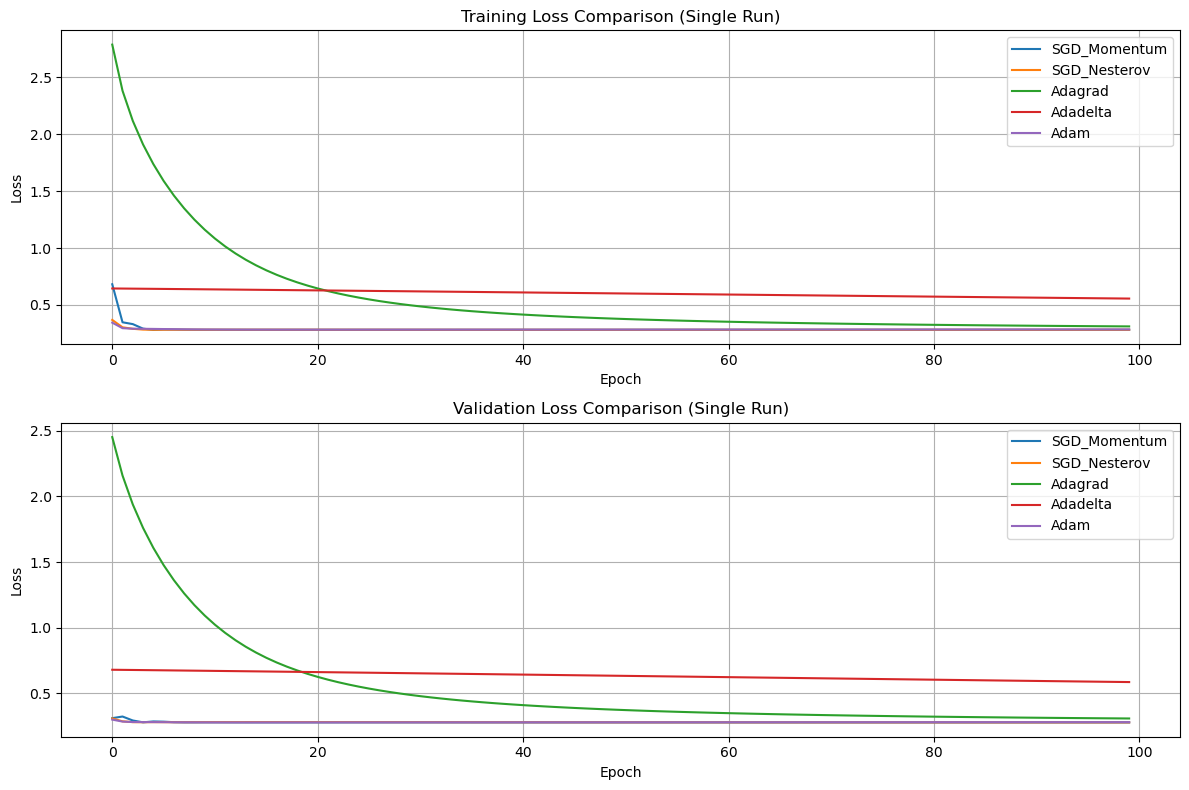

In [6]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
for optimizer_name, history in optimizer_histories.items():
    if 'loss' in history.history:
        plt.plot(history.history['loss'], label=f"{optimizer_name}")
plt.title('Training Loss Comparison (Single Run)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
for optimizer_name, history in optimizer_histories.items():
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label=f"{optimizer_name}")
plt.title('Validation Loss Comparison (Single Run)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Visualize Training Progress (Accuracy Curves from Single Run) - Optional

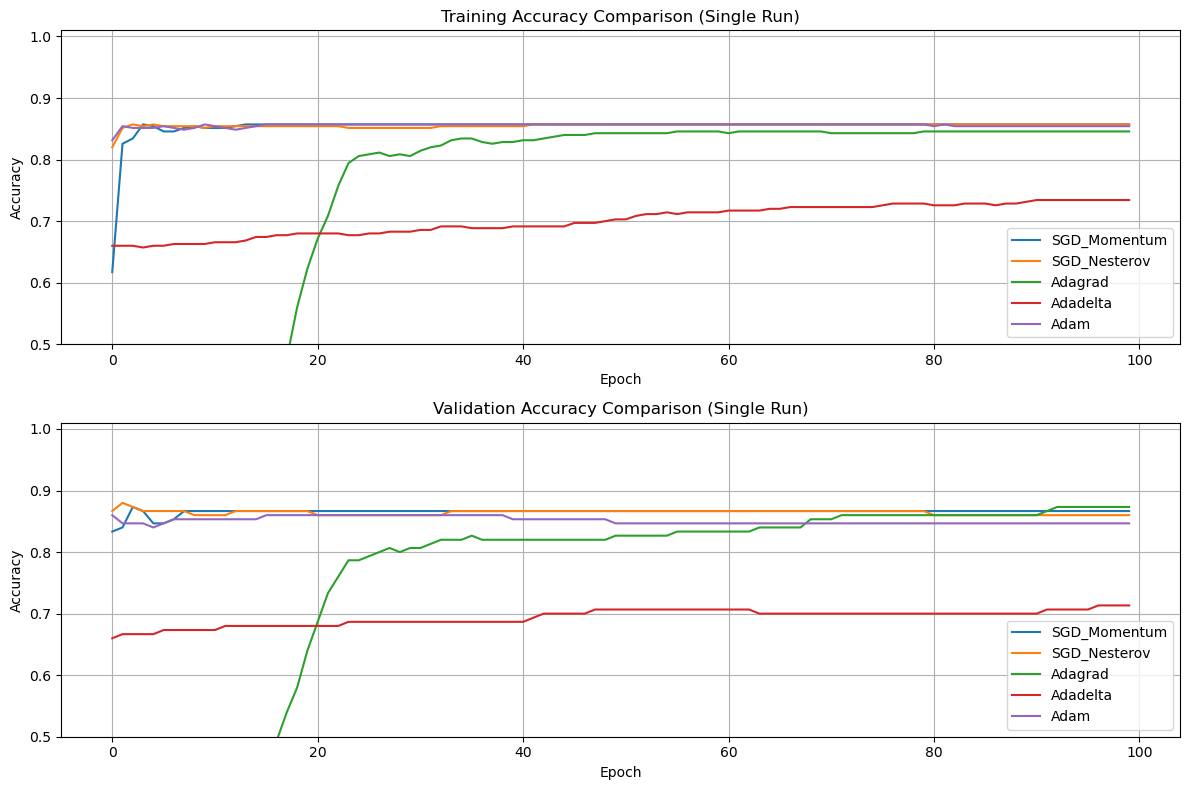

In [7]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
for optimizer_name, history in optimizer_histories.items():
    if 'accuracy' in history.history:
        plt.plot(history.history['accuracy'], label=f"{optimizer_name}")
plt.title('Training Accuracy Comparison (Single Run)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1.01) 
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
for optimizer_name, history in optimizer_histories.items():
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label=f"{optimizer_name}")
plt.title('Validation Accuracy Comparison (Single Run)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1.01)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Discussion of Results (Based on Single Run Plots)

**Interpreting the Plots (you should answer these based on your results):**

*   Which optimizer converged the fastest (in terms of epochs to reach a low loss/high accuracy)?
*   Were there any optimizers that got stuck or showed very slow progress?
*   Did any optimizer show significant oscillations in the loss?
*   How did Nesterov momentum compare to standard momentum?
*   How did the adaptive learning rate methods (Adagrad, Adadelta, Adam) perform compared to the SGD variants?
*   Which optimizer achieved the best final validation performance?

*Note: The performance can be sensitive to the learning rate and other hyperparameters. This illustration uses a common learning rate for most, but in practice, each optimizer might benefit from specific tuning.*

## Average Test Performance Over Multiple Seeds

Now, we will run each optimizer 10 times with different random seeds (0 to 9) to get a more robust measure of performance.

In [8]:
num_experiments = 10
seeds = list(range(num_experiments))

averaged_optimizer_performance = {}

print(f"\n--- Averaging Performance Over {num_experiments} Seeds ---")

for optimizer_name, optimizer_instance_template in optimizers_to_test.items():
    print(f"\nEvaluating Optimizer: {optimizer_name}")
    
    current_val_accuracies = []
    current_val_losses = []

    # Re-instantiate optimizer for each set of experiments to reset its state if stateful (like Adam's moments)
    # For stateless optimizers like SGD, this isn't strictly necessary but good practice.
    # Keras optimizers are re-created from their config when model.compile is called, 
    # or we can explicitly re-create them here from the template if they have internal state
    # that persists across .compile calls if the same instance is used.
    # For simplicity, Keras usually handles this well when model.compile is called with the optimizer config.

    for i, seed_val in enumerate(seeds):
        print(f"  Run {i+1}/{num_experiments} with seed {seed_val}...")
        np.random.seed(seed_val)
        tf.random.set_seed(seed_val)
        
        model = create_model() # Fresh model with new seed-based initialization
        
        # Get a fresh optimizer instance. This is important for optimizers with adaptive learning rates (Adam, Adagrad, etc.)
        # as their internal state (accumulated gradients/moments) should be reset for each independent run.
        current_optimizer_config = optimizer_instance_template.get_config()
        current_optimizer = optimizer_instance_template.__class__.from_config(current_optimizer_config)

        model.compile(optimizer=current_optimizer, 
                      loss='binary_crossentropy', 
                      metrics=['accuracy'])
        
        history = model.fit(X_train, y_train, 
                            epochs=epochs, 
                            batch_size=batch_size, 
                            validation_data=(X_test, y_test), 
                            verbose=0)
        
        current_val_accuracies.append(history.history['val_accuracy'][-1])
        current_val_losses.append(history.history['val_loss'][-1])
        
    # Calculate average and standard deviation
    avg_val_accuracy = np.mean(current_val_accuracies)
    std_val_accuracy = np.std(current_val_accuracies)
    avg_val_loss = np.mean(current_val_losses)
    std_val_loss = np.std(current_val_losses)
    
    averaged_optimizer_performance[optimizer_name] = {
        'avg_val_accuracy': avg_val_accuracy,
        'std_val_accuracy': std_val_accuracy,
        'avg_val_loss': avg_val_loss,
        'std_val_loss': std_val_loss,
        'all_val_accuracies': current_val_accuracies # Optional: store all for further analysis
    }
    
    print(f"  {optimizer_name} - Avg Val Accuracy: {avg_val_accuracy:.4f} (+/- {std_val_accuracy:.4f}) | Avg Val Loss: {avg_val_loss:.4f} (+/- {std_val_loss:.4f})")

# Create a summary DataFrame
summary_list = []
for name, metrics in averaged_optimizer_performance.items():
    summary_list.append({
        'Optimizer': name,
        'Avg Val Accuracy': metrics['avg_val_accuracy'],
        'Std Val Accuracy': metrics['std_val_accuracy'],
        'Avg Val Loss': metrics['avg_val_loss'],
        'Std Val Loss': metrics['std_val_loss']
    })

summary_df = pd.DataFrame(summary_list)
print("\n--- Summary of Averaged Performance ---")
print(summary_df.to_string(index=False))


--- Averaging Performance Over 10 Seeds ---

Evaluating Optimizer: SGD_Momentum
  Run 1/10 with seed 0...
  Run 2/10 with seed 1...
  Run 3/10 with seed 2...
  Run 4/10 with seed 3...
  Run 5/10 with seed 4...
  Run 6/10 with seed 5...
  Run 7/10 with seed 6...
  Run 8/10 with seed 7...
  Run 9/10 with seed 8...
  Run 10/10 with seed 9...
  SGD_Momentum - Avg Val Accuracy: 0.8667 (+/- 0.0000) | Avg Val Loss: 0.2781 (+/- 0.0003)

Evaluating Optimizer: SGD_Nesterov
  Run 1/10 with seed 0...
  Run 2/10 with seed 1...
  Run 3/10 with seed 2...
  Run 4/10 with seed 3...
  Run 5/10 with seed 4...
  Run 6/10 with seed 5...
  Run 7/10 with seed 6...
  Run 8/10 with seed 7...
  Run 9/10 with seed 8...
  Run 10/10 with seed 9...
  SGD_Nesterov - Avg Val Accuracy: 0.8653 (+/- 0.0027) | Avg Val Loss: 0.2781 (+/- 0.0005)

Evaluating Optimizer: Adagrad
  Run 1/10 with seed 0...
  Run 2/10 with seed 1...
  Run 3/10 with seed 2...
  Run 4/10 with seed 3...
  Run 5/10 with seed 4...
  Run 6/10 with se

## Discussion of Averaged Results

**Interpreting the Averaged Results (you should answer these based on your observations):**

*   Which optimizer shows the highest average validation accuracy?
*   Which optimizer has the lowest average validation loss?
*   Consider the standard deviation: Which optimizers are more consistent in their performance across different random initializations? A lower standard deviation indicates more stability.
*   Are there any significant differences in ranking or conclusions when comparing the single run to the averaged results?
*   Based on both average performance and consistency (standard deviation), which optimizer would you recommend for this problem?
*   With the learning rate to be 0.1, how do these optimizers perform on average?

*This more rigorous evaluation helps in making a more informed decision about optimizer choice, as single runs can sometimes be misleading due to lucky/unlucky weight initializations.*